In [89]:
#p247参照
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz

# データセットの読み込み
iris = load_iris()
X = iris.data
y = iris.target

# print("X", X)
# print("y", y)

# モデルリストの作成
models = {
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=4),
    'LinearRegression': LinearRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'MLPClassifier': MLPClassifier(max_iter=2000)
}

logreg = LogisticRegression()# ロジスティック回帰モデルの作成

# 交差検証の準備
#cvのパラメータにX, yは含まれない。分割の仕方を定義しているだけ。データ分割は未実施。
#KFoldはindexで分割している。
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# 決定木モデルの準備
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
gbrt = GradientBoostingClassifier()

tree_feature_importances = np.zeros(X.shape[1])# 各foldごとの特徴量の重要度を保存するリスト
forest_feature_importances = np.zeros(X.shape[1])
gbrt_feature_importances = np.zeros(X.shape[1])

test_scores_mean = []
df_test_scores = pd.DataFrame()
for model_name, model in models.items():
    print(f"=== {model_name} ===")
    # 訓練スコアを計算（cross_val_scoreはテストスコアのみを計算するので手動で行う）
    df_packed_test_scores = pd.DataFrame()
    for train_index, test_index in cv.split(X, y):#cv.split(X, y)により、X, yそれぞれが5分割されたindex配列が返される。
        
        #どう分割されたか確認
        
        # print('train_index:', train_index)
        # print('test_index:', test_index)
        
        #print('X[0]_data:\n', X[0]) #⇒特徴量は1サンプル当たり4つ
        #print('train_data:\n', X[train_index])
        #print('test_data:\n', X[test_index])
        
        #print('y[0]_data:\n', y[0]) #⇒特徴量は1サンプル当たり1つ
        #print('train_data:\n', y[train_index])
        #print('test_data:\n', y[test_index])
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # モデルを訓練
        model.fit(X_train, y_train)
        
        # 特徴量の重要度を計算
        if model_name == 'DecisionTreeClassifier':
            tree_feature_importances += model.feature_importances_  # 各分割の特徴量重要度を加算
        elif model_name == 'RandomForestClassifier':
            forest_feature_importances += model.feature_importances_
        elif model_name == 'GradientBoostingClassifier':
            gbrt_feature_importances += model.feature_importances_
    
        test_score = model.score(X_test, y_test)
        df_packed_test_scores = pd.concat([df_packed_test_scores, pd.DataFrame([test_score])], ignore_index=True)
        print("test score: {:.3f}   ".format(model.score(X_test, y_test)), "train score: {:.3f}".format(model.score(X_train, y_train)))
    df_test_scores = pd.concat([df_test_scores, df_packed_test_scores], ignore_index=True, axis=1)
    mean_score = df_packed_test_scores.mean().values[0]
    test_scores_mean.append(mean_score)
    
tree_feature_importances /= cv.get_n_splits()# 特徴量の重要度の平均を取る（総和を分割数で割る）
forest_feature_importances /= cv.get_n_splits()
gbrt_feature_importances /= cv.get_n_splits()

=== LogisticRegression ===
test score: 1.000    train score: 0.967
test score: 0.833    train score: 0.975
test score: 1.000    train score: 0.967
test score: 1.000    train score: 0.975
test score: 0.933    train score: 0.983
=== LinearSVC ===
test score: 1.000    train score: 0.958
test score: 0.867    train score: 0.983
test score: 1.000    train score: 0.975
test score: 0.967    train score: 0.967
test score: 0.933    train score: 0.975
=== DecisionTreeClassifier ===
test score: 1.000    train score: 1.000
test score: 0.900    train score: 1.000
test score: 1.000    train score: 1.000
test score: 0.900    train score: 1.000
test score: 0.933    train score: 1.000
=== KNeighborsClassifier ===
test score: 1.000    train score: 0.950
test score: 0.867    train score: 0.992
test score: 1.000    train score: 0.958
test score: 1.000    train score: 0.958
test score: 0.933    train score: 0.975
=== LinearRegression ===
test score: 0.906    train score: 0.934
test score: 0.842    train sco

In [90]:
print("tree_feature_importances", tree_feature_importances)
print("forest_feature_importances", forest_feature_importances)
print("gbrt_feature_importances", gbrt_feature_importances)

tree_feature_importances [0.01559007 0.00250679 0.2583502  0.72355294]
forest_feature_importances [0.09972607 0.02536595 0.45262409 0.42228389]
gbrt_feature_importances [0.00566555 0.0098941  0.42446271 0.55997765]


In [91]:
import pandas as pd
df_test_scores.columns = ['LogisticRegression', 'LinearSVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'LinearRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier']
df_test_scores

,LogisticRegression,LinearSVC,DecisionTreeClassifier,KNeighborsClassifier,LinearRegression,RandomForestClassifier,GradientBoostingClassifier,MLPClassifier
0,1.000000,1.000000,1.000000,1.000000,0.905503,0.966667,1.000000,1.000000
1,0.833333,0.866667,0.900000,0.866667,0.841859,0.866667,0.900000,0.933333
2,1.000000,1.000000,1.000000,1.000000,0.945698,1.000000,1.000000,1.000000
3,1.000000,0.966667,0.900000,1.000000,0.962310,1.000000,0.966667,1.000000
4,0.933333,0.933333,0.933333,0.933333,0.933661,0.900000,0.933333,0.933333


In [92]:
df_test_scores.describe()

,LogisticRegression,LinearSVC,DecisionTreeClassifier,KNeighborsClassifier,LinearRegression,RandomForestClassifier,GradientBoostingClassifier,MLPClassifier
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.953333,0.953333,0.946667,0.960000,0.917806,0.946667,0.960000,0.973333
std,0.073030,0.055777,0.050553,0.059628,0.047247,0.060553,0.043461,0.036515
min,0.833333,0.866667,0.900000,0.866667,0.841859,0.866667,0.900000,0.933333
25%,0.933333,0.933333,0.900000,0.933333,0.905503,0.900000,0.933333,0.933333
50%,1.000000,0.966667,0.933333,1.000000,0.933661,0.966667,0.966667,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.945698,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.962310,1.000000,1.000000,1.000000


In [93]:
best_score = max(test_scores_mean)#最大平均スコア
best_method_index = test_scores_mean.index(best_score)#最大値を持つモデルのインデックス
best_model_name = list(models.keys())[best_method_index]#モデル名の取得
print("BestMethod is ", best_model_name, " : ", "{0:.4f}".format(best_score))

BestMethod is  MLPClassifier  :  0.9733


In [94]:
#train_test_splitの場合

In [95]:
def plot_feature_importances_iris(model):
    n_features = X.shape[1]#a.shape[0]はaの行(row)の数、a.shape[1]は列(col)の数
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), iris.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

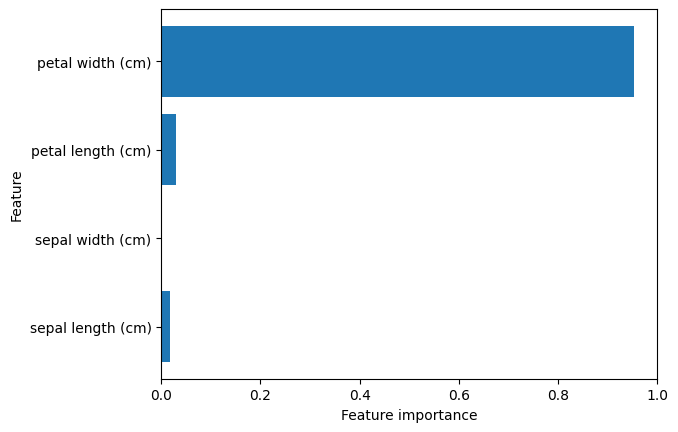

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
plot_feature_importances_iris(tree)

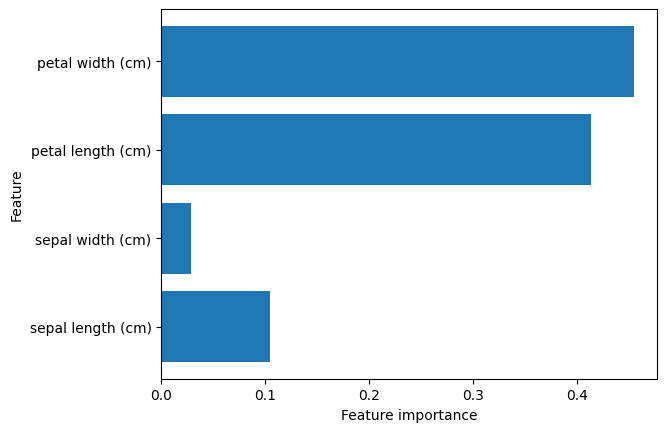

In [141]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
plot_feature_importances_iris(forest)

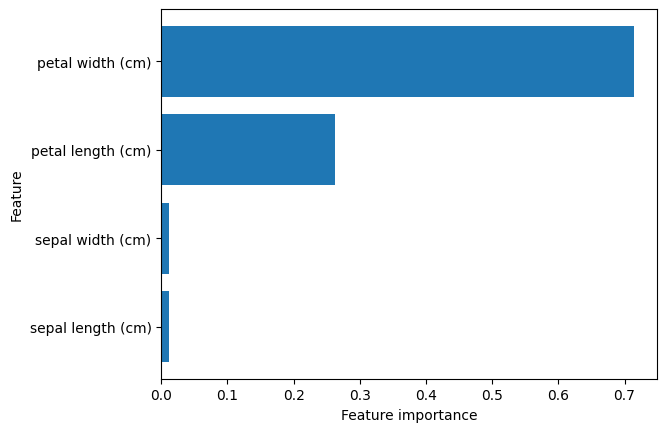

In [154]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
plot_feature_importances_iris(gbrt)

In [99]:
#交差検証で得られた5回の訓練テストにおける、各feature_importancesの平均を表示した場合

In [100]:
# def plot_feature_importances_iris_2(model_feature_importances):
#     n_features = X.shape[1]#a.shape[0]はaの行(row)の数、a.shape[1]は列(col)の数
#     plt.barh(range(n_features), model_feature_importances, align='center')
#     plt.yticks(np.arange(n_features), iris.feature_names)
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")

In [101]:
# plot_feature_importances_iris_2(tree_feature_importances)

In [102]:
# plot_feature_importances_iris_2(forest_feature_importances)

In [103]:
# plot_feature_importances_iris_2(gbrt_feature_importances)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [105]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["L", "a", "b"], feature_names=iris.feature_names, impurity=False, filled=True)

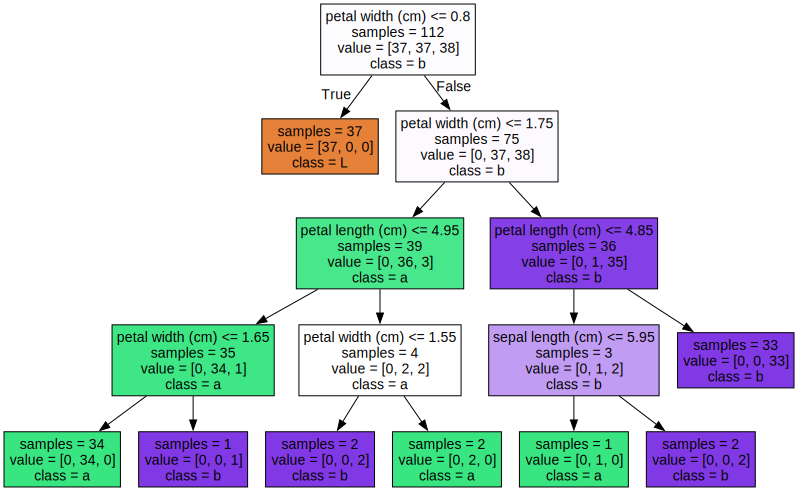

In [106]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)